In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Imports

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch.optim as optim
from os import listdir
from os.path import isfile, join
from tracin.tracin import (
    save_tracin_checkpoint,
    load_tracin_checkpoint,
    calculate_tracin_influence,
)
import pandas as pd
from LSTM_clean.utils import filter_and_split_data, sequence_generator, load_community_dict, get_communities, shannon_index, gini_simpson_index, num_unique, average_diversity
from LSTM_clean import utils
from LSTM_clean.model import LSTM 
from collections import Counter
import numpy as np
import pickle
from collections import defaultdict
import copy
from torch.optim import SGD
from lstm_wrapper import train_model, get_topk_predictions
import matplotlib.pyplot as plt
from copy import deepcopy
import math
import seaborn as sns
import random
sns.set(style='darkgrid')

# Analysis Tools

In [5]:
def plot_counts(counts: dict[str, int], title='placholder_title', xlabel='x', ylabel='count') -> plt.Figure:
    """Plots a histogram from dict"""
    fig = plt.figure()

    # Creating the barplot
    plt.bar(counts.keys(), counts.values())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

def line_plot(hm):
    # line plot
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(sorted(hm.keys()), [hm[x] for x in sorted(hm.keys())])

# Loading data

In [6]:
# Data Location
# Use SAVE_PREFIX to mark different datasets
SAVE_PREFIX = ""
SAVE_FOLDER = os.path.join(os.getcwd(), "data/twitch_sequence/")
SAVE_TRAIN_NAME = SAVE_PREFIX + "train.data"
SAVE_VALID_NAME = SAVE_PREFIX + "valid.data"
SAVE_TEST_NAME = SAVE_PREFIX + "test.data"
SAVE_COMMUNITY_NAME = SAVE_PREFIX + "lstm_idx_communities.data"

In [7]:
train_data = np.load(os.path.join(SAVE_FOLDER, SAVE_TRAIN_NAME), allow_pickle=True)
valid_data = np.load(os.path.join(SAVE_FOLDER, SAVE_VALID_NAME), allow_pickle=True)
test_data = np.load(os.path.join(SAVE_FOLDER, SAVE_TEST_NAME), allow_pickle=True)

# Bucketing Training Data

In [8]:
community_dict = load_community_dict(os.path.join(SAVE_FOLDER, SAVE_COMMUNITY_NAME))

In [9]:
# Generate sequences and gt
sequences = [pt[0] for pt in train_data]
gt = [pt[1] for pt in train_data]

## Bucket #1 - Filter Bubble

In [10]:
def is_filter_bubble(sequence, label):
    communities = get_communities(sequence, community_dict)
    hm_communities = Counter(communities)
    for k, v in hm_communities.items():
        if v >= 0.95 * len(communities) and k == community_dict[label]:
            return 1.0
    return 0.0

In [11]:
# Filter bubble
nums = []
train_pts_filter_bubble = []
for i, sequence in enumerate(sequences):
    if len(get_communities(sequence, community_dict)) <= 30:
        continue
    nums.append(is_filter_bubble(sequence, gt[i]))
    if nums[-1] == 1:
        train_pts_filter_bubble.append([sequence, gt[i]])
with open(os.path.join(SAVE_FOLDER, 'train_pts_filter_bubble.data'), "wb+") as f:
    pickle.dump(train_pts_filter_bubble, f)

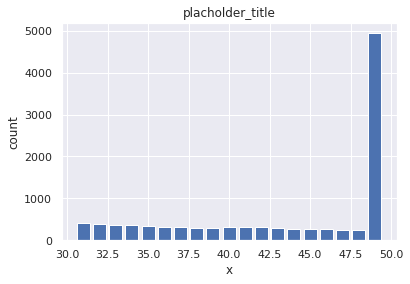

In [12]:
plot_counts(Counter(len(get_communities(x[0], community_dict)) for x in train_pts_filter_bubble))

In [13]:
len(train_pts_filter_bubble)

10582

## Bucket #2 - Breaking Bubble

In [24]:
# Checks label is a brand new community
def is_breaking_bubble(sequence, label):
    communities = get_communities(sequence, community_dict)
    hm_communities = Counter(communities)
    for k, v in hm_communities.items():
        if v >= 0.8 * len(communities) and community_dict[label] not in communities:
            return 1.0
    return 0.0

In [114]:
# Breaking bubble
nums = []
train_pts_breaking_bubble = []
for i, sequence in enumerate(sequences):
    if len(get_communities(sequence, community_dict)) < 8:
        continue
    nums.append(is_breaking_bubble(sequence, gt[i]))
    if nums[-1] == 1:
        train_pts_breaking_bubble.append([sequence, gt[i]])
with open(os.path.join(SAVE_FOLDER, 'train_pts_breaking_bubble.data'), "wb+") as f:
    pickle.dump(train_pts_breaking_bubble, f)

In [95]:
len(train_pts_breaking_bubble)

819

## Bucket #3 - Diverse

In [27]:
def is_diverse(sequence, label):
    communities = get_communities(sequence, community_dict)
    diversity = gini_simpson_index(communities, community_dict)
    if diversity > 0.5 and community_dict[label] not in communities:
        return 1.0
    return 0.0

In [115]:
# Diverse pts
nums = []
train_pts_diverse = []
for i, sequence in enumerate(sequences):
    nums.append(is_diverse(sequence, gt[i]))
    if nums[-1] == 1:
        train_pts_diverse.append([sequence, gt[i]])
with open(os.path.join(SAVE_FOLDER, 'train_pts_diverse.data'), "wb+") as f:
    pickle.dump(train_pts_diverse, f)

In [116]:
len(train_pts_diverse)

2201

# Bucketing Validation Data

## Loading Model

In [14]:
# Parameter may need to change if you re-ran all the prior pre-processing experiments
OUTPUT_SIZE=1743

device = torch.device("cuda")
print("Device is", device)
model = LSTM(input_size=128, output_size=OUTPUT_SIZE, hidden_dim=64, n_layers=1, device=device) 
model.LSTM.flatten_parameters()
optimizer = optim.SGD(model.parameters(), lr=5e-2, momentum=0.9)
model.to(device)

Device is cuda


LSTM(
  (item_emb): Embedding(1743, 128, padding_idx=0)
  (LSTM): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1743, bias=True)
)

In [15]:
model, _, epoch, loss = load_tracin_checkpoint(model, optimizer, os.path.join(os.getcwd(), "checkpoints/lstm_checkpoint_epoch600.pt"))

## Loading Communities and Generating Labels

In [16]:
community_dict = load_community_dict(os.path.join(SAVE_FOLDER, SAVE_COMMUNITY_NAME))

In [18]:
# Generate sequences and gt
sequences = [pt[0] for pt in valid_data]
gt = [pt[1] for pt in valid_data]

# Generate predictions
predictions = get_topk_predictions(model, sequences, k=10)

## Bucket #1 - Filter Bubble

In [19]:
assert len(sequences) == len(predictions)

In [41]:
nums = []
valid_pts_filter_bubble = []
for i, sequence in enumerate(sequences):
    if len(get_communities(sequence, community_dict)) <= 30:
        continue
    for next_item in predictions[i]:
        assert len(predictions[i]) <= 10
        nums.append(is_filter_bubble(sequence, next_item))
        if nums[-1] == 1:
            valid_pts_filter_bubble.append([sequence, next_item])
with open(os.path.join(SAVE_FOLDER, 'valid_pts_filter_bubble.data'), "wb+") as f:
    pickle.dump(valid_pts_filter_bubble, f)

In [39]:
len(valid_pts_filter_bubble)

30689

In [33]:
# for i in range(5):
#     print(get_communities(valid_pts_filter_bubble[i][0], community_dict))
#     print(get_communities([valid_pts_filter_bubble[i][1]], community_dict))
#     print('\n')

## Bucket #2 - Breaking Bubble

In [42]:
nums = []
valid_pts_breaking_bubble = []
for i, sequence in enumerate(sequences):
    for next_item in predictions[i]:
        nums.append(is_breaking_bubble(sequence, next_item))
        if nums[-1] == 1:
            valid_pts_breaking_bubble.append([sequence, next_item])
with open(os.path.join(SAVE_FOLDER, 'valid_pts_breaking_bubble.data'), "wb+") as f:
    pickle.dump(valid_pts_breaking_bubble, f)

In [36]:
len(valid_pts_breaking_bubble)

1379

In [43]:
# for i in range(5):
#     print(get_communities(valid_pts_breaking_bubble[i][0], community_dict))
#     print(get_communities([valid_pts_breaking_bubble[i][1]], community_dict))
#     print('\n')

In [44]:
SAVE_FOLDER

'/raid/home/myang349/mitigating-filter-bubbles-final/recsys-filterbubbles/data/twitch_sequence/'